# Analysis and merge of climate, land and biodiversity datasets

The description of this notebook is based on the data retrieved from France, similar assumptions can be done for ***

In [3]:
import os
import sys
import cdsapi
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import netCDF4 as nc
import numpy as np
import xarray as xa
import pandas as pd
import glob
import matplotlib.pyplot as plt
from scipy import stats

module_path = os.path.abspath(os.path.join('./get_dataset'))
if module_path not in sys.path:
    sys.path.append(module_path)

import dataset_api as api

In [4]:
getTrain = False

lat_france = [44.4, 44.8]
lon_france = [3.6, 4.5]
# lat up - lon left - lat down - lon right
area_france = [lat_france[1], lon_france[0], lat_france[0], lon_france[1]]

if(getTrain):
    x = 0
else:
    lat = lat_france
    lon = lon_france
    area = area_france

## Climate

The climate dataset has been retrieved from the ERA5 dataset, it has a 0.1° precision and all features are numerical. To facilitate our future work, we're going to multiply the latitude and longitude by 100 and transform them to integer 

In [5]:
folder = '.'
path = folder + '/ERA5_land.nc'
#api.get_era5_land(path, area)

In [6]:
with xa.open_mfdataset(path) as ds:
    df_cds = ds.to_dataframe() 

### Averaging on time values

df_cds = df_cds.groupby(['longitude', 'latitude']).mean()
#df_cds.index = df_cds.index.map(lambda index: (int(index[0]*100), int(index[1]*100)))
df_cds.describe()

,d2m,t2m,fal,lai_hv,lai_lv,src,skt,stl1,stl2,stl3,...,ssr,str,sp,ssrd,strd,tp,swvl1,swvl2,swvl3,swvl4
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,5.000000e+01,5.000000e+01,50.000000,5.000000e+01,5.000000e+01,50.000000,50.000000,50.000000,50.000000,50.000000
mean,277.906830,283.634460,0.149582,2.272012,1.862344,0.000094,283.440033,283.942963,283.900208,283.809967,...,1.265538e+07,-5.465522e+06,92296.187500,1.484091e+07,2.615528e+07,0.003564,0.336618,0.336026,0.333673,0.380165
std,1.196573,2.108817,0.015131,0.107650,1.118679,0.000011,2.051336,2.110281,2.092695,2.040334,...,3.324496e+05,4.740959e+05,3692.234619,2.331968e+05,4.869775e+05,0.000294,0.032687,0.032980,0.030233,0.022927
min,276.375305,280.984344,0.118431,2.043380,0.000000,0.000070,280.870087,281.327118,281.299072,281.267242,...,1.200220e+07,-6.313198e+06,87798.937500,1.440962e+07,2.551018e+07,0.002922,0.291388,0.288257,0.290002,0.353493
25%,276.847977,281.760452,0.138531,2.221962,0.668805,0.000087,281.560310,282.057701,282.029694,281.982285,...,1.242665e+07,-5.890868e+06,89155.564453,1.465304e+07,2.574418e+07,0.003333,0.314262,0.314859,0.313716,0.369773
50%,277.419510,283.012695,0.147721,2.271453,2.403568,0.000092,282.949402,283.415359,283.387314,283.324188,...,1.269948e+07,-5.319614e+06,90779.097656,1.482950e+07,2.607223e+07,0.003621,0.337814,0.338170,0.331044,0.376256
75%,278.887589,285.251740,0.159517,2.324144,2.732013,0.000100,285.099365,285.631172,285.583420,285.474335,...,1.292557e+07,-5.099571e+06,95183.937500,1.500334e+07,2.655170e+07,0.003823,0.353296,0.352702,0.348353,0.381225
max,279.959473,287.241272,0.180966,2.704039,2.993403,0.000116,287.188690,287.708008,287.626099,287.440399,...,1.321991e+07,-4.757877e+06,98520.781250,1.534874e+07,2.714875e+07,0.003994,0.436943,0.435818,0.431686,0.470464


### Null data

As we can see, the dataset is complete and there are no null values

In [7]:
print("Are there null values? ", df_cds.isna().any().any())

Are there null values?  False


### Plotting the data

We can see how almost all datas follow a constant increse/decrease pattern with big spike caused from the transition in latitude (the indexes are ordered longitude first).

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023CC832E8E0>,
      dtype=object)

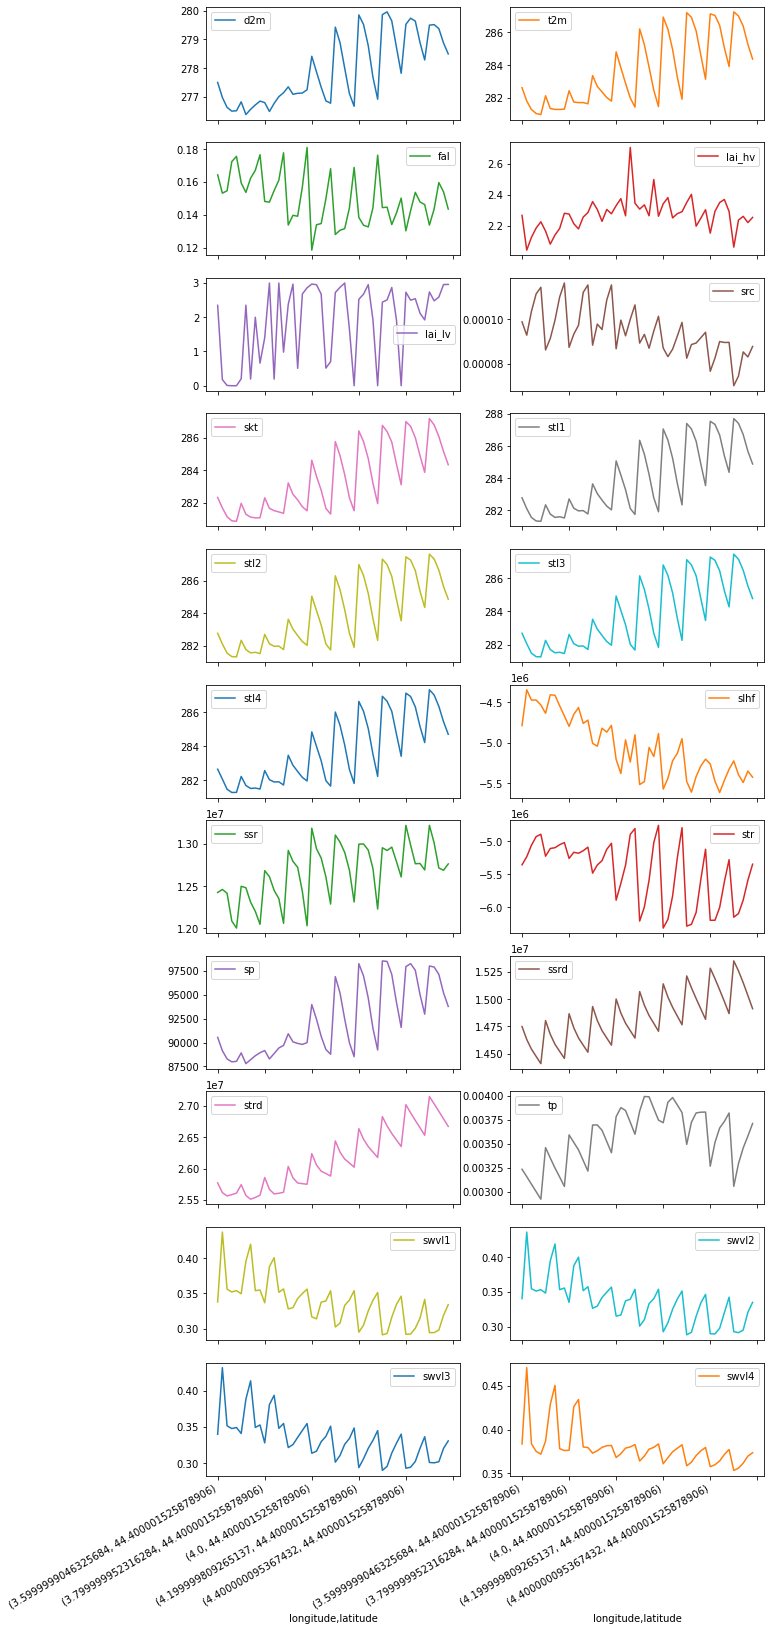

In [8]:
df_cds.plot(subplots=True, layout=(11,2), figsize=[10, 30])

## Land Dataset

The land dataset has been retrieved from the *Copernicus Land Service*, we manually checked the feature and excluded some of them.

In [9]:
df_land = pd.read_csv('./france_land_v2.csv')
df_land = df_land.drop(columns=['Unnamed: 0'])

# Retrieving only data of our location
df_land = df_land.loc[(df_land['latitude'] >= lat[0]) & (df_land['latitude'] <= lat[1]) 
                        & (df_land['longitude'] >= lon[0]) & (df_land['longitude'] <= lon[1])]

df_land = df_land.set_index(['longitude', 'latitude'])
#df_land.index = df_land.index.map(lambda index: (int(index[0]*100), int(index[1]*100)))

# Manually excluding features
df_land = df_land.drop(columns=['DMP300-RT0-QFLAG', 'GDMP300-RT0-QFLAG', 'FAPAR300-RT0-NOBS', 
                                'FAPAR300-RT0-LENGTH-AFTER','FAPAR300-RT0-QFLAG', 'FAPAR300-RT0-RMSE',
                               'FAPAR300-RT0-LENGTH-BEFORE', 'FCOVER300-RT0-QFLAG','FCOVER300-RT0-LENGTH-AFTER',
                                'FCOVER300-RT0-NOBS', 'FCOVER300-RT0-LENGTH-BEFORE','FCOVER300-RT0-RMSE', 
                               'LAI300-RT0-LENGTH-BEFORE','LAI300-RT0-LENGTH-AFTER', 'LAI300-RT0-NOBS',
                                'LAI300-RT0-RMSE', 'LAI300-RT0-QFLAG','SWI1km-QFLAG-015', 'SWI1km-QFLAG-020',
                                'SWI1km-QFLAG-060', 'SWI1km-QFLAG-010', 'SWI1km-SSF',
                                'SWI1km-QFLAG-005', 'SWI1km-QFLAG-100', 'SWI1km-QFLAG-040',
                                'SWI1km-QFLAG-002', 'SSM1km-ssm-noise', 'LST-Q-FLAGS', 
                                'LST-PERCENT-PROC-PIXELS', 'LST-ERRORBAR-LST','LST-TIME-DELTA',
                               'ALDH-AL-DH-QFLAG', 'ALDH-NMOD', 'ALDH-LMK', 'ALDH-AL-DH-BB-ERR',
                                'ALDH-AL-DH-VI-ERR', 'ALDH-AL-DH-NI-ERR', 'ALBH-LMK',
                                'ALBH-NMOD', 'ALBH-AL-BH-QFLAG','ALBH-AL-BH-BB-ERR', 
                                'ALBH-AL-BH-VI-ERR', 'ALBH-AL-BH-NI-ERR', 
                               'TOCR-TOCR-QFLAG', 'TOCR-NMOD','TOCR-REF-NOR-SWIR-ERR', 
                                'TOCR-REF-NOR-RED-ERR','TOCR-REF-NOR-BLUE-ERR', 'TOCR-SZN',
                                'TOCR-REF-NOR-NIR-ERR', 'BA300-FDOB-DEKAD', 'BA300-BA-DEKAD',
                                'BA300-FDOB-SEASON', 'BA300-CP-DEKAD', 'SSM1km-ssm'])

# Temporary removing untile further notice
df_land = df_land.drop(columns=['DMP300-RT0-DMP'])


### First observation

Before starting to clean the dataset, we have to do an observation. The choosen data span over an entire area defined by coordinates, they include both land and sea data but our job is to devine the biodiversity of land areas, in particular forest.

To remove seas data we can use the *GDMP300-RT0-GDMP* columns whose value are set to less than 0 for sea data.

In [10]:
print("number of sea data: ", (df_land['GDMP300-RT0-GDMP'] < 0).sum())
df_land = df_land[df_land['GDMP300-RT0-GDMP'] != -2]

number of sea data:  6


### Null values

By counting the null values for each column we can see that some of them are null in almost all of our dataset.

In [11]:
df_land_null_cols = df_land.isnull().sum()
print("Unique number of null values per columns: ", df_land_null_cols.unique())
print("Number of columns with null count >= 3000: ", len(df_land_null_cols[df_land_null_cols >= 15000].index))

null_cols = df_land_null_cols[df_land_null_cols >= 3000].index
print("Columns with mostly null values: ", null_cols)
df_land = df_land.drop(columns=null_cols)

Unique number of null values per columns:  [   0 3537 3426]
Number of columns with null count >= 3000:  0
Columns with mostly null values:  Index(['LST-LST', 'VCI_x'], dtype='object')


We check for other null values

In [12]:
print("Are there null values? ", df_land.isna().sum())

Are there null values?  NDVI                    0
ALBH-AL-BH-NI           0
ALBH-AL-BH-VI           0
ALBH-AL-BH-BB           0
ALDH-AL-DH-BB           0
ALDH-AL-DH-NI           0
FAPAR300-RT0-FAPAR      0
GDMP300-RT0-GDMP        0
LAI300-RT0-LAI          0
SWI1km-SWI-002          0
SWI1km-SWI-100          0
SWI1km-SWI-040          0
SWI1km-SWI-005          0
SWI1km-SWI-010          0
SWI1km-SWI-060          0
SWI1km-SWI-015          0
SWI1km-SWI-020          0
TOCR-REF-NOR-BLUE       0
TOCR-REF-NOR-NIR        0
TOCR-REF-NOR-SWIR       0
TOCR-REF-NOR-RED        0
VCI_y                   0
FCOVER300-RT0-FCOVER    0
ALDH-AL-DH-VI           0
dtype: int64


### Handle outliers and wrong values

Firstly we plot the different features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023CC8336F40>,
      dtype=object)

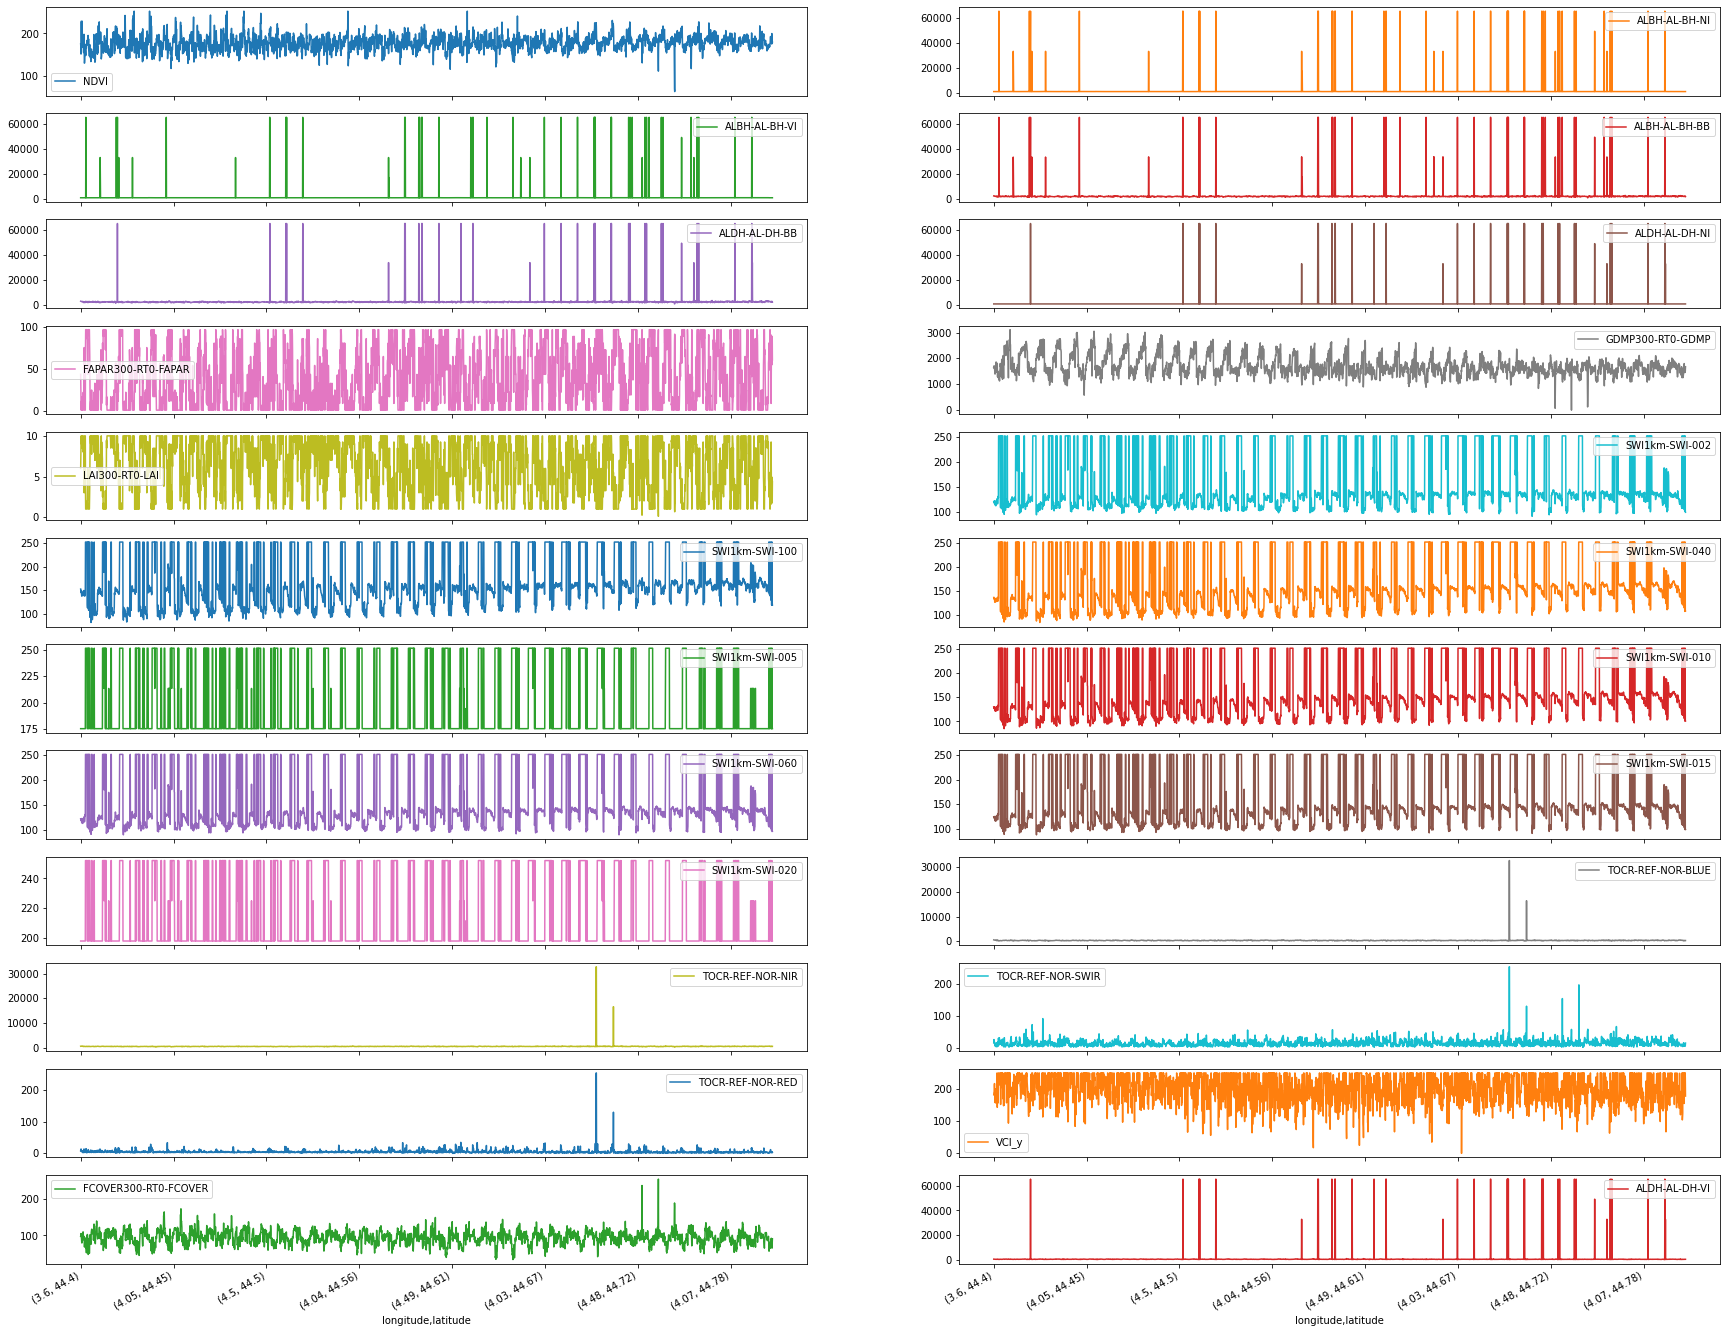

In [13]:
df_land.plot(subplots=True, layout=(14,2), figsize=(30,30))

#### Albedo

For the albedo features (*ALBH* ans *ALDH*) the maximum value should be 10000 and some specif values are used:

- 65535 for invalid values
- 65534 for values with out of range value inferior to the minimum physical value
- 65533 for values with out of range value superior to the max physical value

To align the values we will firstly set 65534 to 0, 65533 and every other value greater than 10000 to 10000

In [66]:
albedo_labels = ['ALBH-AL-BH-NI', 'ALBH-AL-BH-VI', 'ALBH-AL-BH-BB',
       'ALDH-AL-DH-BB', 'ALDH-AL-DH-VI', 'ALDH-AL-DH-NI']
df_land_albedo = df_land[albedo_labels].copy()

df_land_albedo[df_land_albedo == 65534] = 0
df_land_albedo[df_land_albedo > 10000] = 10000

df_land_albedo.describe()

,ALBH-AL-BH-NI,ALBH-AL-BH-VI,ALBH-AL-BH-BB,ALDH-AL-DH-BB,ALDH-AL-DH-VI,ALDH-AL-DH-NI
count,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000
mean,1209.221341,967.537557,1869.364389,2468.936053,304.538430,954.156098
std,14.013361,8.732381,194.649329,269.766939,79.924834,4.398599
min,1187.000000,954.000000,1252.000000,1621.000000,73.000000,949.000000
25%,1199.000000,962.000000,1746.000000,2290.000000,251.250000,951.000000
50%,1205.000000,965.000000,1869.364389,2468.936053,294.000000,953.000000
75%,1213.000000,969.500000,1992.375000,2649.000000,347.000000,955.000000
max,1262.000000,1001.000000,2518.500000,3366.000000,562.500000,972.000000


To detect the outliers we will use the quartile and interquartile range and define a value as outliers if $z_{score} > 3$ 

Count of outliers:

In [67]:
mask = (np.abs(stats.zscore(df_land_albedo)) > 3)

df_land_albedo[mask] = None
df_land_albedo.isna().sum()

ALBH-AL-BH-NI    43
ALBH-AL-BH-VI    40
ALBH-AL-BH-BB     9
ALDH-AL-DH-BB     8
ALDH-AL-DH-VI    23
ALDH-AL-DH-NI    65
dtype: int64

Now that we know what are the outliers, we can correct them by taking the average of the 4 closest coordinates

In [68]:
# Not yet implemented
'''def get_avg_value(dataset, mask, lon, lat, precision, standard_value, margin):
    values = [standard_value] * 4
    # up, left, down, right same as margin array
    directions = [[0, 1], [-1, 0], [0, -1], [1, 0]]
    
    i = precision
    for dir, p in enumerate(directions):
        i = precision
        while(i <= margin[p]):
            if(mask.loc[i, lat+precision]):
                up = dataset.loc[lon, lat+precision]
                break;
    
    return np.mean(values)
'''

df_land_albedo.fillna(df_land_albedo.mean(), inplace=True)
df_land_albedo.describe()
#for coord in mask[mask == False].index:
#    df_land_albedo.loc[coord] = get_avg_value(df_land_albedo, mask)

,ALBH-AL-BH-NI,ALBH-AL-BH-VI,ALBH-AL-BH-BB,ALDH-AL-DH-BB,ALDH-AL-DH-VI,ALDH-AL-DH-NI
count,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000
mean,1208.664327,967.210917,1868.855452,2467.574162,302.993975,953.884354
std,13.025806,8.147531,192.315686,266.902526,77.482950,3.893323
min,1187.000000,954.000000,1297.000000,1667.000000,73.000000,949.000000
25%,1199.000000,962.000000,1746.000000,2290.000000,251.250000,951.000000
50%,1205.000000,965.000000,1869.364389,2468.936053,294.000000,953.000000
75%,1212.000000,969.000000,1991.500000,2647.375000,346.500000,954.500000
max,1251.000000,993.500000,2450.000000,3272.000000,543.000000,967.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023CCF61CB20>,
      dtype=object)

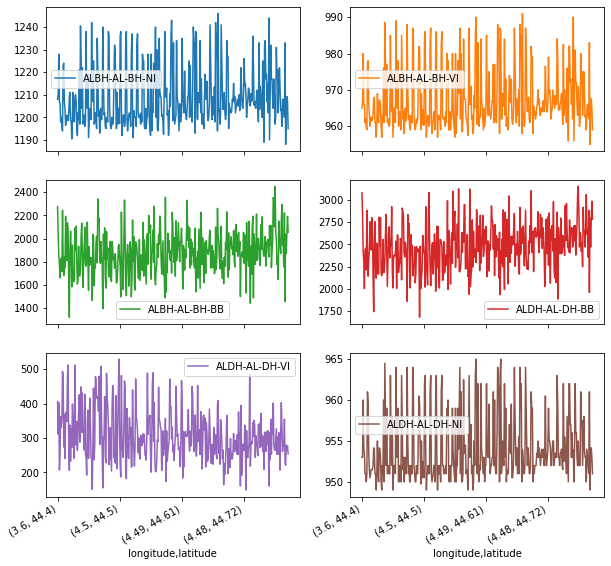

In [69]:
df_land_albedo[::10].plot(subplots=True, layout=(3,2), figsize=(10,10))

The *ALDH-AL-DH-VI* has a strange range of values despite using the same unit of measure as the others albedo variables. We're going to keep it and assume the data have been scaled.

In [20]:
df_land[albedo_labels] = df_land_albedo

#### TOC Reflectance

Top-Of-Canopy (TOC) spectral reflectance quantifies the fraction of the sunlight reflected by the surface of the Earth, in a given spectral band. The physical max value is 1.2 and is transposed in a (0, 2400) range.

As we did for the albedo, we're going to explore the data to find outliers and adjust the specific values. In this case the invalid values are set to 32767 for *TOCR-REF-NOR-BLUE* and *TOCR-REF-NOR-NIR* and 255 for *TOCR-REF-NOR-SWIR* and *TOCR-REF-NOR-RED*

In [59]:
tocr_labels = ['TOCR-REF-NOR-BLUE', 'TOCR-REF-NOR-NIR', 'TOCR-REF-NOR-SWIR', 'TOCR-REF-NOR-RED']

df_land_tocr = df_land[tocr_labels].copy()

for col in tocr_labels[0:1]:
    df_land_tocr[df_land[col] == 32767] = df_land[col].mean()

for col in tocr_labels[2:3]:
    df_land_tocr[df_land[col] == 255] = df_land[col].mean()

#df_land_tocr[df_land[ 'TOCR-REF-NOR-SWIR', 'TOCR-REF-NOR-RED'] == 255] = df_land[ 'TOCR-REF-NOR-SWIR', 'TOCR-REF-NOR-RED'].mean()

In [60]:
mask = (np.abs(stats.zscore(df_land_tocr)) > 3)

df_land_tocr[mask] = None
df_land_tocr.fillna(df_land_tocr.mean(), inplace=True)
df_land_tocr.describe()

,TOCR-REF-NOR-BLUE,TOCR-REF-NOR-NIR,TOCR-REF-NOR-SWIR,TOCR-REF-NOR-RED
count,3726.000000,3726.000000,3726.000000,3726.000000
mean,377.652871,490.017502,13.830785,4.599051
std,77.361591,55.252616,7.764433,2.898264
min,14.471820,14.471820,2.000000,0.000000
25%,323.625000,455.500000,8.000000,3.000000
50%,375.000000,487.000000,12.000000,4.000000
75%,429.875000,522.687500,18.000000,5.000000
max,644.000000,691.000000,43.000000,18.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023CCE205A00>,
      dtype=object)

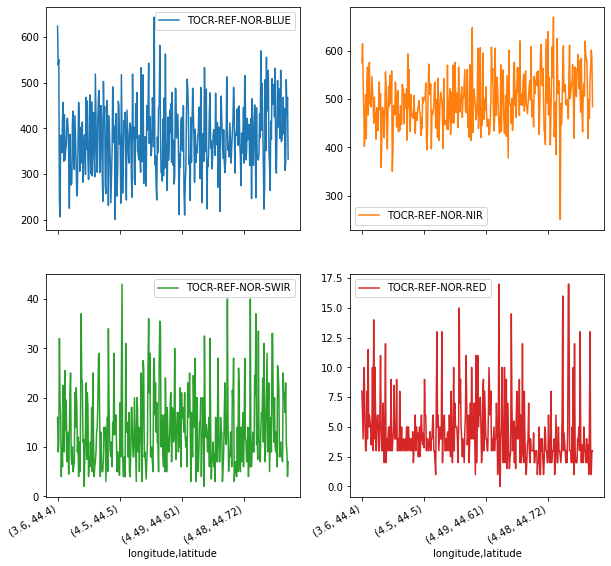

In [61]:
df_land_tocr[::10].plot(subplots=True, layout=(2,2), figsize=(10,10))

In [70]:
df_land[tocr_labels] = df_land_tocr

#### SWI

For Soil Water Index the values should be in a range (0, 200) and 255 is used for errors. Since almost third of the values are greater than 200, we're assuming that the scale reported on the site is different than the one used and take them as valid

SWI1km-SWI-002    0.268116
SWI1km-SWI-100    0.271873
SWI1km-SWI-040    0.268116
SWI1km-SWI-005    0.289318
SWI1km-SWI-010    0.268116
SWI1km-SWI-060    0.268116
SWI1km-SWI-015    0.268116
SWI1km-SWI-020    0.289855
dtype: float64


,SWI1km-SWI-002,SWI1km-SWI-100,SWI1km-SWI-040,SWI1km-SWI-005,SWI1km-SWI-010,SWI1km-SWI-060,SWI1km-SWI-015,SWI1km-SWI-020
count,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000
mean,158.770733,169.516573,166.582864,196.466385,163.237386,159.267110,160.340446,213.054348
std,58.074848,54.510263,55.741617,34.060168,57.219701,58.191698,58.031145,23.886351
min,91.000000,81.000000,85.000000,175.000000,85.000000,90.000000,87.000000,198.000000
25%,116.625000,126.625000,120.500000,175.000000,116.000000,115.000000,114.000000,198.000000
50%,133.000000,157.000000,152.000000,175.000000,146.250000,136.000000,140.000000,198.000000
75%,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
max,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000


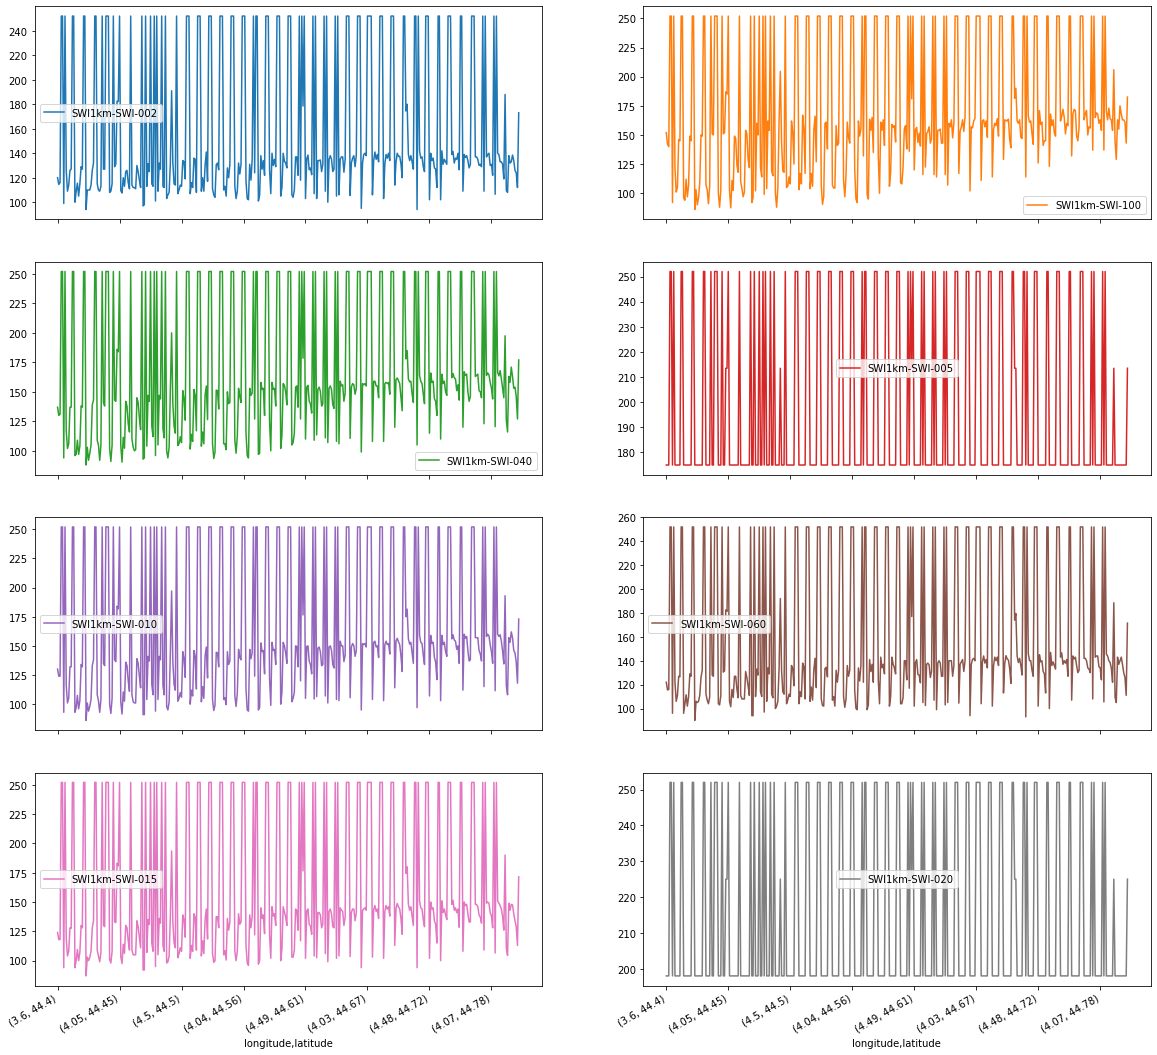

In [74]:
swi_labels = ['SWI1km-SWI-002', 'SWI1km-SWI-100',
       'SWI1km-SWI-040', 'SWI1km-SWI-005', 'SWI1km-SWI-010', 'SWI1km-SWI-060',
       'SWI1km-SWI-015', 'SWI1km-SWI-020']

df_land_swi = df_land[swi_labels].copy()
for col in swi_labels:
    df_land_swi[df_land_swi[col] == 255] = df_land_swi[col].mean()

print(df_land_swi[df_land_swi > 200].count() / df_land_swi.shape[0])
df_land_swi[::10].plot(subplots=True, layout=(4,2), figsize=(20,20))
df_land_swi.describe()

In [75]:
df_land[swi_labels] = df_land_swi

#### Other columns

Other columns are fine and don't need to be preprocessed

,NDVI,FAPAR300-RT0-FAPAR,GDMP300-RT0-GDMP,LAI300-RT0-LAI,VCI_y,FCOVER300-RT0-FCOVER
count,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000
mean,177.613763,38.351762,1713.957167,6.496090,199.779321,94.840190
std,17.346144,34.655369,384.382395,3.251110,41.808644,18.247453
min,64.500000,1.000000,-1.777778,0.111111,0.000000,33.833333
25%,166.703125,1.000000,1454.166667,3.812500,171.000000,83.557292
50%,177.111111,33.000000,1636.875000,7.000000,201.000000,95.222222
75%,188.333333,67.000000,1902.145833,10.000000,241.500000,106.333333
max,252.000000,97.000000,3112.222222,10.000000,250.000000,255.000000


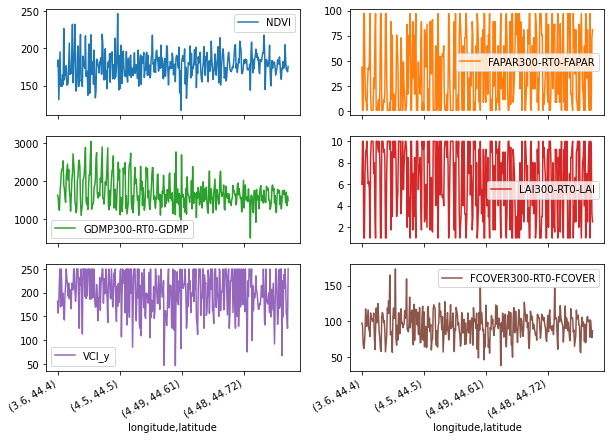

In [76]:
df_land_other = df_land.drop(columns=albedo_labels + tocr_labels + swi_labels)
df_land_other[::10].plot(subplots=True, layout=(4,2), figsize=(10,10))
df_land_other.describe()

## Merge of Climate and Land dataset

In [77]:
def distance(lon1, lon2, lat1, lat2):
    return np.sqrt((lon1-lon2)**2 + (lat1-lat2)**2)

df1 = df_cds.reset_index()
df2 = df_land.reset_index()

minimum = [-1] * df2.shape[0]
coords_y = df1.values[:, 0:2]
for i, [lon_x, lat_x] in enumerate(df2.values[:, 0:2]):
    distances = list(map(lambda coord_y: distance(lon_x, coord_y[0], lat_x, coord_y[1]), coords_y))
    minimum[i] = np.argmin(distances)

df1.drop(columns=['longitude', 'latitude'], inplace=True)
df2['merge_index'] = minimum
df = df2.merge(df1, left_on='merge_index', right_index=True).drop(columns=['merge_index'])
df.set_index(['longitude', 'latitude'], inplace=True)

## Add biodiversity index

In [ ]:

df.to_csv('merged_dataset.csv')

# Regression on biodiversity index

In [53]:
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 

In [59]:
regression_label = 'lai_hv'

y = df[regression_label].values
X = df.drop(columns=[regression_label]).values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [60]:
svm_model = svm.SVR().fit(X_train, y_train)
tree_model = DecisionTreeRegressor().fit(X_train, y_train)
linear_model = LinearRegression(fit_intercept = True, normalize = True, copy_X = True, n_jobs = 2).fit(X_train, y_train)
rand_forest_model = RandomForestRegressor(n_estimators = 100, random_state = 0).fit(X_train, y_train)

print("SVM score: ", svm_model.score(X_test,y_test))
print("Tree score: " , tree_model.score(X_test,y_test))
print("Linear Regression score: " , linear_model.score(X_test,y_test))
print("Random forest score: ", rand_forest_model.score(X_test,y_test))
print("-"*50)
print("SVM cross validation: ", np.mean(cross_val_score(svm_model, X, y, cv=10)))
print("Tree cross validation: ", np.mean(cross_val_score(tree_model, X, y, cv=10)))
print("Linear Regression cross validation: ", np.mean(cross_val_score(linear_model, X, y, cv=10)))
print("Random forest cross validation: ", np.mean(cross_val_score(rand_forest_model, X, y, cv=10)))

SVM score:  0.7377752724674004
Tree score:  1.0
Linear Regression score:  0.9804462109785353
Random forest score:  0.9999999905517255
--------------------------------------------------
SVM cross validation:  -0.8737785433824182
Tree cross validation:  -0.22764559127117634
Linear Regression cross validation:  0.5865820717953487
Random forest cross validation:  -0.034590582093816935
